In [2]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
import holidays
import geopandas as gpd

# In this Notebook we will do with the following:

- Merge the Taxi Data with NY_taxi_zones. (The NY_taxi_zones csv file contain description about the Location ID Borough and Zone)

- Merge the Taxi Data with Weather dataframe. ( weather information for New York City - Data taken from Visual Crossing.com)

- Merge the Taxi Data with Holiday Dataframe. ( New York holidays information)

- perform exploratory data analysis



## 1- Load the taxi data

__We will load the hourly aggregated taxi data we got from Spark preprocessing stage__

__Note all the 3 parquet files are in `all_together` folder, we will read them combined__

In [32]:
files_directory=r"C:\Users\agssh\Desktop\simple_project\Thesis files\all_together"

In [33]:
df=pd.read_parquet(files_directory,engine='auto')

In [34]:
df.head()

,timestamp,hourly_timestamp,locationID,Pick_Trips_count,Drop_Trips_count,Year,Month,DayOfMonth,Hour,dayofweek
0,2022-01-01,2022-01-01 00:00,120,0,1,2022,1,1,0,7
1,2022-01-01,2022-01-01 00:00,133,0,0,2022,1,1,0,7
2,2022-01-01,2022-01-01 00:00,137,59,65,2022,1,1,0,7
3,2022-01-01,2022-01-01 00:00,160,0,0,2022,1,1,0,7
4,2022-01-01,2022-01-01 00:00,166,11,22,2022,1,1,0,7


In [35]:
# Sort the dataframe based on timestamp
df.sort_values(by=['timestamp', 'locationID'], ascending = [True, False], inplace=True)

In [36]:
df = df.reset_index(drop=True)

In [37]:
df.drop(['hourly_timestamp'],axis=1, inplace=True)

In [38]:
df.head()

,timestamp,locationID,Pick_Trips_count,Drop_Trips_count,Year,Month,DayOfMonth,Hour,dayofweek
0,2020-01-01,265,12,36,2020,1,1,0,4
1,2020-01-01,264,73,44,2020,1,1,0,4
2,2020-01-01,263,390,301,2020,1,1,0,4
3,2020-01-01,262,149,236,2020,1,1,0,4
4,2020-01-01,261,51,62,2020,1,1,0,4


In [39]:
#rename location ID
df.rename(columns = {'locationID':'LocationID'}, inplace = True)

In [40]:
df.count()

timestamp           5348208
LocationID          5348208
Pick_Trips_count    5348208
Drop_Trips_count    5348208
Year                5348208
Month               5348208
DayOfMonth          5348208
Hour                5348208
dayofweek           5348208
dtype: int64

In [41]:
len(df)

5348208

## 2- Join taxi data with NY_taxi_zones

__Now we will Load the `NY_taxi_zones` csv file to join it with df__

In [42]:
# 1. Import Location and Borough columns form NY TAXI ZONES dataset
dfzones = pd.read_csv('NY_taxi_zones.csv', sep=',',usecols=['LocationID', 'Borough', 'Zone'])

In [43]:
dfzones.head()

,LocationID,Borough,Zone
0,1,EWR,Newark Airport
1,2,Queens,Jamaica Bay
2,3,Bronx,Allerton/Pelham Gardens
3,4,Manhattan,Alphabet City
4,5,Staten Island,Arden Heights


In [44]:
df =df.merge(dfzones, on='LocationID', how='left')

__Now we will create string column from the timestamp to make it easier to join it with the weather dataframe__

In [45]:
df['String_datetime'] = df['timestamp'].dt.strftime('%Y-%m-%d%-H%M')

In [31]:
df.head()

,timestamp,LocationID,Pick_Trips_count,Drop_Trips_count,Year,Month,DayOfMonth,Hour,dayofweek,Borough,Zone,String_datetime
0,2020-01-01,265,12,36,2020,1,1,0,4,Unknown,NaN,2020-01-01 00:00:00
1,2020-01-01,264,73,44,2020,1,1,0,4,Unknown,NV,2020-01-01 00:00:00
2,2020-01-01,263,390,301,2020,1,1,0,4,Manhattan,Yorkville West,2020-01-01 00:00:00
3,2020-01-01,262,149,236,2020,1,1,0,4,Manhattan,Yorkville East,2020-01-01 00:00:00
4,2020-01-01,261,51,62,2020,1,1,0,4,Manhattan,World Trade Center,2020-01-01 00:00:00


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5348208 entries, 0 to 5348207
Data columns (total 12 columns):
 #   Column            Dtype         
---  ------            -----         
 0   timestamp         datetime64[ns]
 1   LocationID        int32         
 2   Pick_Trips_count  int64         
 3   Drop_Trips_count  int64         
 4   Year              int32         
 5   Month             int32         
 6   DayOfMonth        int32         
 7   Hour              int32         
 8   dayofweek         int32         
 9   Borough           object        
 10  Zone              object        
 11  String_datetime   object        
dtypes: datetime64[ns](1), int32(6), int64(2), object(3)
memory usage: 408.0+ MB


## 3- Join taxi data with wather data

#### Loading the wather data

In [47]:
df_temp=pd.read_csv('new york_weather.csv',usecols=['datetime','temp','humidity','precip','snow','windspeed'])

In [48]:
df_temp.head()

,datetime,temp,humidity,precip,snow,windspeed
0,2020-01-01T00:00:00,5.1,58.68,0.0,0.0,19.6
1,2020-01-01T01:00:00,4.4,57.83,0.0,0.0,16.6
2,2020-01-01T02:00:00,4.0,61.40,0.0,0.0,17.8
3,2020-01-01T03:00:00,4.0,59.42,0.0,0.0,22.2
4,2020-01-01T04:00:00,3.9,55.18,0.0,0.0,20.1


In [49]:
df_temp['datetime']= df_temp['datetime'].astype('datetime64[ns]')

In [50]:
df_temp['String_datetime'] = df_temp['datetime'].dt.strftime('%Y-%m-%d%-H%M')

__Since the taxi data contain trips from 1-Jan-2020 until 30-Apr-2022, then we will choose the same period from the weather dataframe__

In [51]:
df_temp=df_temp[(df_temp['datetime'] < '2022-05-01')]

In [52]:
df_temp

,datetime,temp,humidity,precip,snow,windspeed,String_datetime
0,2020-01-01 00:00:00,5.1,58.68,0.0,0.0,19.6,2020-01-01 00:00:00
1,2020-01-01 01:00:00,4.4,57.83,0.0,0.0,16.6,2020-01-01 01:00:00
2,2020-01-01 02:00:00,4.0,61.40,0.0,0.0,17.8,2020-01-01 02:00:00
3,2020-01-01 03:00:00,4.0,59.42,0.0,0.0,22.2,2020-01-01 03:00:00
4,2020-01-01 04:00:00,3.9,55.18,0.0,0.0,20.1,2020-01-01 04:00:00
...,...,...,...,...,...,...,...
20419,2022-04-30 19:00:00,16.3,24.38,0.0,0.0,9.4,2022-04-30 19:00:00
20420,2022-04-30 20:00:00,14.6,24.35,0.0,0.0,8.3,2022-04-30 20:00:00
20421,2022-04-30 21:00:00,14.1,25.06,0.0,0.0,3.4,2022-04-30 21:00:00
20422,2022-04-30 22:00:00,13.8,27.55,0.0,0.0,4.1,2022-04-30 22:00:00


__Now Merging the taxi dataframe with  weather dataframe__

In [53]:
df_final=df.merge(df_temp, on='String_datetime', how='left')

In [54]:
df_final.head()

,timestamp,LocationID,Pick_Trips_count,Drop_Trips_count,Year,Month,DayOfMonth,Hour,dayofweek,Borough,Zone,String_datetime,datetime,temp,humidity,precip,snow,windspeed
0,2020-01-01,265,12,36,2020,1,1,0,4,Unknown,NaN,2020-01-01 00:00:00,2020-01-01,5.1,58.68,0.0,0.0,19.6
1,2020-01-01,264,73,44,2020,1,1,0,4,Unknown,NV,2020-01-01 00:00:00,2020-01-01,5.1,58.68,0.0,0.0,19.6
2,2020-01-01,263,390,301,2020,1,1,0,4,Manhattan,Yorkville West,2020-01-01 00:00:00,2020-01-01,5.1,58.68,0.0,0.0,19.6
3,2020-01-01,262,149,236,2020,1,1,0,4,Manhattan,Yorkville East,2020-01-01 00:00:00,2020-01-01,5.1,58.68,0.0,0.0,19.6
4,2020-01-01,261,51,62,2020,1,1,0,4,Manhattan,World Trade Center,2020-01-01 00:00:00,2020-01-01,5.1,58.68,0.0,0.0,19.6


In [55]:
len(df_final)

5348208

In [56]:
df_final.isnull().sum()

timestamp               0
LocationID              0
Pick_Trips_count        0
Drop_Trips_count        0
Year                    0
Month                   0
DayOfMonth              0
Hour                    0
dayofweek               0
Borough                 0
Zone                20424
String_datetime         0
datetime                0
temp                    0
humidity                0
precip                  0
snow                    0
windspeed               0
dtype: int64

__We dont need `String_datetime`,`datetime` since its dublicated so we will drop them__

In [57]:
drop_columns=['String_datetime','datetime']

In [58]:
df_final.drop(drop_columns, inplace=True, axis=1)

## 4- Join taxi data with holidays

The holiday package will be used in python to create the  holiday dataframe that will contain the holiday name and date.
To merge holiday dataframe with taxi dataframe, we will need to create a new column in taxi dataframe that only contains the date since the taxi dataframe contain hourly timestamp

In [59]:
# Creating date string column in taxi dataframe in this format DDMMYYYY
df_final['date']=df_final['timestamp'].apply(lambda x: x.strftime('%d%m%Y'))

In [62]:
df_final.head()

,timestamp,LocationID,Pick_Trips_count,Drop_Trips_count,Year,Month,DayOfMonth,Hour,dayofweek,Borough,Zone,temp,humidity,precip,snow,windspeed,date
0,2020-01-01,265,12,36,2020,1,1,0,4,Unknown,NaN,5.1,58.68,0.0,0.0,19.6,01012020
1,2020-01-01,264,73,44,2020,1,1,0,4,Unknown,NV,5.1,58.68,0.0,0.0,19.6,01012020
2,2020-01-01,263,390,301,2020,1,1,0,4,Manhattan,Yorkville West,5.1,58.68,0.0,0.0,19.6,01012020
3,2020-01-01,262,149,236,2020,1,1,0,4,Manhattan,Yorkville East,5.1,58.68,0.0,0.0,19.6,01012020
4,2020-01-01,261,51,62,2020,1,1,0,4,Manhattan,World Trade Center,5.1,58.68,0.0,0.0,19.6,01012020


__Now we will import holiday information for `2020,2021,2022` using holiday package__

In [60]:
# creating holidays dataset based on United states

holiday_list = []
for holiday in holidays.UnitedStates(years=[2020, 2021,2022]).items():
    holiday_list.append(holiday)

holidays_df = pd.DataFrame(holiday_list, columns=["date", "holiday"])
holidays_df.head()

,date,holiday
0,2020-01-01,New Year's Day
1,2020-01-20,Martin Luther King Jr. Day
2,2020-02-17,Washington's Birthday
3,2020-05-25,Memorial Day
4,2020-07-04,Independence Day


In [63]:
# Creating date string column in taxi dataframe in this format DDMMYYYY
holidays_df['date']=holidays_df['date'].apply(lambda x: x.strftime('%d%m%Y'))

In [64]:
# Creating new column contain 1 for the holiday
holidays_df['Holiday']=1

In [65]:
df_final=df_final.merge(holidays_df, on='date', how='left')

In [66]:
len(df_final)

5348208

In [67]:
df_final.isnull().sum()

timestamp                 0
LocationID                0
Pick_Trips_count          0
Drop_Trips_count          0
Year                      0
Month                     0
DayOfMonth                0
Hour                      0
dayofweek                 0
Borough                   0
Zone                  20424
temp                      0
humidity                  0
precip                    0
snow                      0
windspeed                 0
date                      0
holiday             5165928
Holiday             5165928
dtype: int64

__Create Is weekend column__

In [68]:
# Create Is weekend column

df_final["IsWeekend"] = df_final["dayofweek"] >= 5

In [69]:
df_final['IsWeekend'].replace({True:1,False:0}, inplace=True)

In [71]:
# we will drop the holiday name and the string date
drop_columns=['holiday','date']

In [72]:
df_final.drop(drop_columns, inplace=True, axis=1)

In [73]:
df_final.head()

,timestamp,LocationID,Pick_Trips_count,Drop_Trips_count,Year,Month,DayOfMonth,Hour,dayofweek,Borough,Zone,temp,humidity,precip,snow,windspeed,Holiday,IsWeekend
0,2020-01-01,265,12,36,2020,1,1,0,4,Unknown,NaN,5.1,58.68,0.0,0.0,19.6,1.0,0
1,2020-01-01,264,73,44,2020,1,1,0,4,Unknown,NV,5.1,58.68,0.0,0.0,19.6,1.0,0
2,2020-01-01,263,390,301,2020,1,1,0,4,Manhattan,Yorkville West,5.1,58.68,0.0,0.0,19.6,1.0,0
3,2020-01-01,262,149,236,2020,1,1,0,4,Manhattan,Yorkville East,5.1,58.68,0.0,0.0,19.6,1.0,0
4,2020-01-01,261,51,62,2020,1,1,0,4,Manhattan,World Trade Center,5.1,58.68,0.0,0.0,19.6,1.0,0


## 5- Exploratory Data Analysis

### 5.1 Pick-up trips per borough

__We want to see which borough have the highest pick-up trips count__

In [74]:
pick_trips_by_borough = df_final.groupby("Borough")["Pick_Trips_count"].sum().sort_values(ascending=False)

In [47]:
pick_trips_by_borough

Borough
Manhattan        61145433
Queens            4387143
Brooklyn           787787
Unknown            740263
Bronx              265635
Staten Island        7771
EWR                  6313
Name: Pick_Trips_count, dtype: int64

__The top Borough in percentage__

In [75]:
pick_percent_borough = (pick_trips_by_borough * 100 / df_final["Pick_Trips_count"].sum())

In [76]:
pick_percent_borough

Borough
Manhattan        90.800594
Queens            6.514880
Brooklyn          1.169859
Unknown           1.099286
Bronx             0.394466
Staten Island     0.011540
EWR               0.009375
Name: Pick_Trips_count, dtype: float64

__As we can see, 90.8% of the New York taxi trips are originated from Manhattan__

In [77]:
pick_count_indices = list(pick_percent_borough.index)

In [79]:
#converting it to dataframe
pick_percentage_trips=pd.DataFrame({'Borough':pick_count_indices,'Percent':pick_percent_borough.values})

### 5.2 Drop-off trips per borough

__We want to see which borough have the highest drop-off trips count__

In [80]:
drop_trips_by_borough = df_final.groupby("Borough")["Drop_Trips_count"].sum().sort_values(ascending=False)

In [81]:
Drop_percentage_borough = (drop_trips_by_borough * 100 / df_final["Drop_Trips_count"].sum())

In [82]:
Drop_percentage_borough

Borough
Manhattan        89.024220
Queens            4.773318
Brooklyn          4.110249
Bronx             1.066167
Unknown           0.819606
EWR               0.172478
Staten Island     0.033961
Name: Drop_Trips_count, dtype: float64

__As we can see, 89% of the New York taxi trips are dropped in Manhattan__

In [83]:
#converting it to dataframe
drop_percentage_trips=pd.DataFrame({'Borough':Drop_percentage_borough.index,'Percent':Drop_percentage_borough.values})

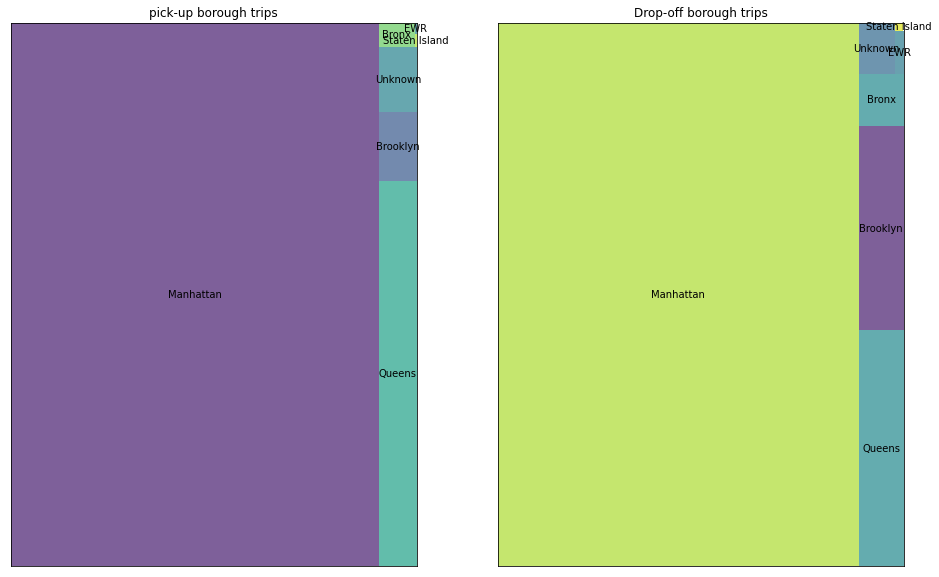

In [85]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,10))
ax1.set_title("pick-up borough trips")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
squarify.plot(sizes=pick_percentage_trips['Percent'], label=pick_percentage_trips['Borough'], alpha=.7, ax=ax1)

ax2.set_title("Drop-off borough trips")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
squarify.plot(sizes=drop_percentage_trips['Percent'], label=drop_percentage_trips['Borough'], alpha=.7, ax=ax2)
plt.show()

__Based on the previous analysis, I have decided to choose only Manhattan Borough for the modeling part.__ 

In [86]:
Manhattan=df_final[df_final['Borough']=='Manhattan']

In [87]:
Manhattan.head()

,timestamp,LocationID,Pick_Trips_count,Drop_Trips_count,Year,Month,DayOfMonth,Hour,dayofweek,Borough,Zone,temp,humidity,precip,snow,windspeed,Holiday,IsWeekend
2,2020-01-01,263,390,301,2020,1,1,0,4,Manhattan,Yorkville West,5.1,58.68,0.0,0.0,19.6,1.0,0
3,2020-01-01,262,149,236,2020,1,1,0,4,Manhattan,Yorkville East,5.1,58.68,0.0,0.0,19.6,1.0,0
4,2020-01-01,261,51,62,2020,1,1,0,4,Manhattan,World Trade Center,5.1,58.68,0.0,0.0,19.6,1.0,0
16,2020-01-01,249,419,173,2020,1,1,0,4,Manhattan,West Village,5.1,58.68,0.0,0.0,19.6,1.0,0
19,2020-01-01,246,214,152,2020,1,1,0,4,Manhattan,West Chelsea/Hudson Yards,5.1,58.68,0.0,0.0,19.6,1.0,0


In [88]:
Manhattan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1368408 entries, 2 to 5348204
Data columns (total 18 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   timestamp         1368408 non-null  datetime64[ns]
 1   LocationID        1368408 non-null  int32         
 2   Pick_Trips_count  1368408 non-null  int64         
 3   Drop_Trips_count  1368408 non-null  int64         
 4   Year              1368408 non-null  int32         
 5   Month             1368408 non-null  int32         
 6   DayOfMonth        1368408 non-null  int32         
 7   Hour              1368408 non-null  int32         
 8   dayofweek         1368408 non-null  int32         
 9   Borough           1368408 non-null  object        
 10  Zone              1368408 non-null  object        
 11  temp              1368408 non-null  float64       
 12  humidity          1368408 non-null  float64       
 13  precip            1368408 non-null  float6

__We have nan values in Holiday column, since any holiday date will be represented by 1, and if there is no holiday it should be zero__ so we will vill this nan values with zero.

In [89]:
Manhattan['Holiday']=Manhattan['Holiday'].fillna(0)

C:\Users\agssh\AppData\Local\Temp/ipykernel_31288/1426039132.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Manhattan['Holiday']=Manhattan['Holiday'].fillna(0)


## Save Manhattan dataframe

In [91]:
Manhattan = Manhattan.reset_index(drop=True)

In [ ]:
Manhattan.to_csv('Manhattan.csv')

In [67]:
print('number of locations in Manhattan :',Manhattan['Zone'].nunique())

number of locations in Manhattan : 67


__So we should have `1368408` rows :(365 X 24 X 67) rows for 2020, (366 X 24 X 67) rows for 2021, (120 X 24 X 67) rows for the first 4 months of 2022__

In [68]:
len(Manhattan)

1368408

## Correlation analysis

<AxesSubplot:>

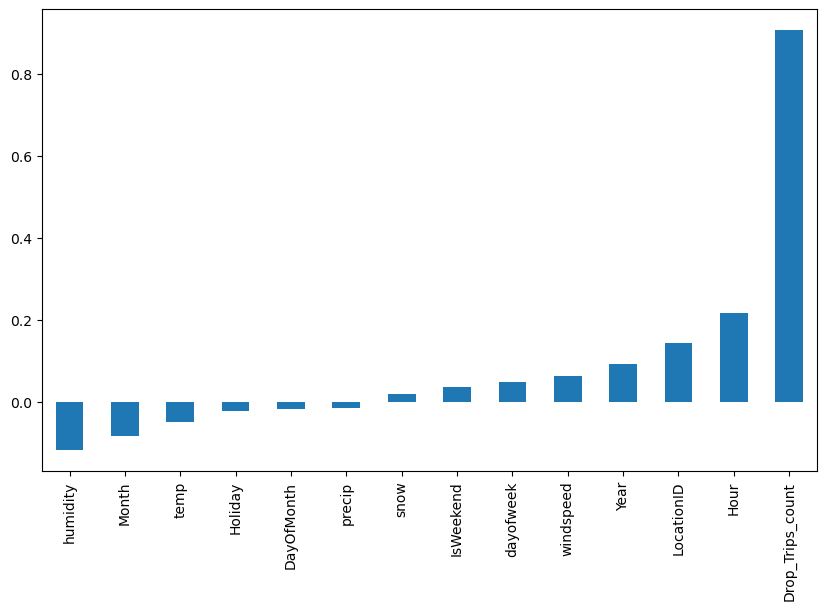

In [69]:
Manhattan.corr()['Pick_Trips_count'].sort_values().drop('Pick_Trips_count').plot(kind='bar',figsize=(10,6))

<AxesSubplot:>

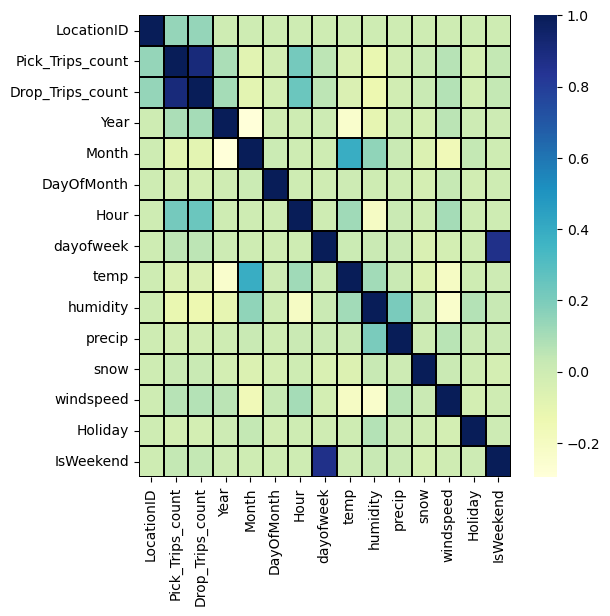

In [70]:
plt.figure(figsize=(6, 6))

sns.heatmap(Manhattan.corr(), linewidth=0.3, linecolor='black', cmap="YlGnBu")

## Ploting the top location on map

In [3]:
df_shape = gpd.read_file('taxi_zones/taxi_zones.shp').to_crs(epsg=3785)

In [73]:
df_shape = df_shape.drop(['Shape_Area', 'Shape_Leng', 'OBJECTID'], axis=1)
# filtering Manhatten area
df_shape = df_shape[df_shape['borough'] == 'Manhattan']

In [74]:
# Get the average 'pickups' by 'LocationID' and cast the number to integer
Manhattan_counts= Manhattan[['LocationID','Pick_Trips_count','Drop_Trips_count']]

In [75]:
# Average Pick-up location
average_pick_location= Manhattan_counts.groupby("LocationID")["Pick_Trips_count"].mean().sort_values(ascending=False).reset_index()

In [76]:
# Rounding the average to integer
average_pick_location=average_pick_location.astype({"Pick_Trips_count": int})

In [77]:
# Average Drop_off location
average_drop_location= Manhattan_counts.groupby("LocationID")["Drop_Trips_count"].mean().sort_values(ascending=False).reset_index()

In [78]:
# Rounding the average to integer
average_drop_location=average_drop_location.astype({"Drop_Trips_count": int})

In [79]:
Average_trips=average_pick_location.merge(average_drop_location, on='LocationID', how='left')

In [80]:
Average_trips

,LocationID,Pick_Trips_count,Drop_Trips_count
0,237,160,140
1,236,149,152
2,161,122,110
3,186,111,72
4,162,106,85
...,...,...,...
62,202,0,1
63,153,0,0
64,128,0,0
65,120,0,0


In [81]:
# Merge 'pickups' with geometry
df_shape_merged = Average_trips.merge(df_shape, left_on='LocationID', right_on='LocationID')

In [82]:
df_shape_merged

,LocationID,Pick_Trips_count,Drop_Trips_count,zone,borough,geometry
0,237,160,140,Upper East Side South,Manhattan,"POLYGON ((-8233871.646 4977326.198, -8233922.3..."
1,236,149,152,Upper East Side North,Manhattan,"POLYGON ((-8232943.947 4979004.836, -8232995.3..."
2,161,122,110,Midtown Center,Manhattan,"POLYGON ((-8234897.601 4976315.150, -8234949.2..."
3,186,111,72,Penn Station/Madison Sq West,Manhattan,"POLYGON ((-8236636.918 4974863.512, -8236687.0..."
4,162,106,85,Midtown East,Manhattan,"POLYGON ((-8234438.215 4976299.518, -8234489.4..."
...,...,...,...,...,...,...
61,194,0,0,Randalls Island,Manhattan,"POLYGON ((-8228335.846 4982545.868, -8228230.7..."
62,202,0,1,Roosevelt Island,Manhattan,"POLYGON ((-8231163.561 4978335.590, -8231249.0..."
63,153,0,0,Marble Hill,Manhattan,"POLYGON ((-8227252.349 4994026.992, -8227281.2..."
64,128,0,0,Inwood Hill Park,Manhattan,"MULTIPOLYGON (((-8229137.222 4994495.628, -822..."


In [83]:
# creating Geo dataframe
df=gpd.GeoDataFrame(df_shape_merged, geometry=df_shape_merged['geometry'], crs="EPSG:4326")

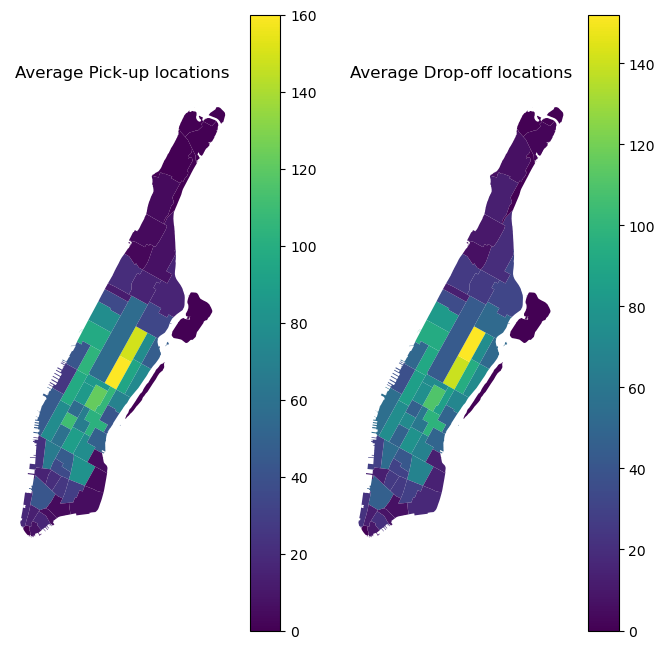

In [85]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,8))
ax1.set_title("Average Pick-up locations")
df.plot(column='Pick_Trips_count', ax=ax1, legend=True)
ax1.set_axis_off()

ax2.set_title("Average Drop-off locations")
df.plot(column='Drop_Trips_count', ax=ax2, legend=True)
ax2.set_axis_off()